# Imports and Classes/Helper Functions

In [189]:
import numpy as np
from matplotlib import pyplot as plt
import os
import requests

In [190]:
class Model:
    """Base class for models."""
    def __init__(self):
        """params is a dictionary mapping parameter names to numpy arrays"""
        self.params = {}

    def predict(self, X):
        """X is a numpy array of shape (N, D), where N is the number of
        D-dimensional data points"""
        raise NotImplementedError

    def loss(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,)"""
        raise NotImplementedError

    def grad(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,).
        This will be a matching dictionary to self.params, with all the same keys
        and for each parameter it will have the gradient which is a numpy array of
        the same shape"""
        raise NotImplementedError

def grad_check(model, X, y, eps = 1e-6):
    """Numerically estimate the gradient of the loss function and compare it to the analytical gradient"""
    grad = model.grad(X, y)
    for param in model.params:
        print(f"Checking {param}:")
        print(f"Analytical gradient {grad[param]}")
        numgrad = np.zeros(grad[param].shape)
        for i, val in np.ndenumerate(model.params[param]):
            model.params[param][i] = val + eps
            loss1 = model.loss(X, y)
            model.params[param][i] = val - eps
            loss2 = model.loss(X, y)
            model.params[param][i] = val
            numgrad[i] = (loss1 - loss2) / (2 * eps)
        print(f"Numerical gradient {numgrad}")
        print(f"Difference {abs(numgrad - grad[param])}")
        print()

class Optimizer:
    def __init__(self, model):
        self.model = model

    def step(self, grad):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__(model)
        self.learning_rate = learning_rate

    def step(self, grad):
        for param in self.model.params:
            self.model.params[param] -= self.learning_rate * grad[param]

class Adam(Optimizer):
    def __init__(self, model, D, b1, b2, lr, off=1e-7):
        super().__init__(model)
        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.off = off
        self.first_mom = {"W":np.zeros(D, dtype=float), "b":np.array(0, dtype=float)}
        self.second_mom = {"W":np.zeros(D, dtype=float), "b":np.array(0, dtype=float)}
        self.t = 0
    
    def step(self, grad):
        self.t += 1
        for param in self.model.params:
            self.first_mom[param] = self.b1*self.first_mom[param] + (1-self.b1) * grad[param]
            self.second_mom[param] = self.b2*self.second_mom[param] + (1-self.b2) * (grad[param]**2)
            first_unbias = self.first_mom[param] / (1-self.b1**self.t)
            second_unbias = self.second_mom[param] / (1-self.b2**self.t)
            self.model.params[param] -= self.lr*first_unbias / (np.sqrt(second_unbias)+self.off)


def train(model, X, y, num_iterations = 100, print_every = 1, optimizer = None):
    """Simple training loop, with no batching."""
    if optimizer is None:
        optimizer = SGD(model)
    for i in range(num_iterations):
        optimizer.step(model.grad(X, y))
        if i % print_every == 0:
            print(f"Iteration {i}: loss {model.loss(X, y)}")
    print("Final", model.loss(X, y))

class MultipleRegression(Model):
    def __init__(self, D, reg=0):
        super().__init__()
        W = np.zeros(D, dtype=float)
        b = np.array(0, dtype=float)
        self.reg = reg
        self.params = {"W": W, "b": b}

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']

    def loss(self, X, y):
        loss = np.mean((self.predict(X) - y) ** 2)
        loss += self.reg * np.sum(self.params['W'] ** 2)
        return loss

    def grad(self, X, y):
        dW = ((2*self.predict(X)-2*y) @ X)/len(X) + (self.reg * 2 * (self.params['W']))
        db = np.array(2*np.mean(self.predict(X)-y))
        return {"W": dW, "b": db}
    
    def fit(self, X, y):
        X_2 = X
        if (X_2.shape[1] == len(self.params['W'])):
            X_2 = np.pad(X, ((0, 0), (0, 1)), mode="constant", constant_values=1)
        mn = np.linalg.inv(X_2.T @ X_2 + np.pad(np.identity(len(X_2.T)-1, dtype=float), ((0, 1), (0, 1)), mode="constant", constant_values=0)*self.reg*len(X_2) ) @ (y @ X_2)
        self.params["W"] = mn[:-1]
        self.params["b"] = np.array(mn[-1])


# Part 1: Multiple Linear Regression

## Small Toy Example

##### data

not like the plot is useful but eh

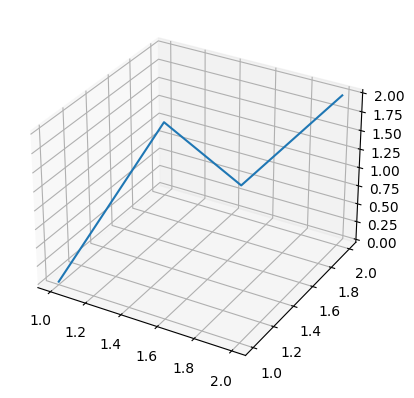

In [191]:
X = np.array([[1,1],
              [1,2],
              [2,1],
              [2,2]], dtype=float)
y = np.array([0,1,2,2], dtype=float)
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*zip(*X), y)

##### gradient check

In [192]:
m = MultipleRegression(2)
grad_check(m, X, y)

Checking W:
Analytical gradient [-4.5 -4. ]
Numerical gradient [-4.5 -4. ]
Difference [1.84911642e-10 1.07021947e-10]

Checking b:
Analytical gradient -2.5
Numerical gradient -2.5000000001274003
Difference 1.2740031252178596e-10



In [193]:
m = MultipleRegression(2, reg = 0.5)
m.params['W'] = np.array([0.,1.])
m.params['b'] = np.array(-1.)
grad_check(m, X, y)

Checking W:
Analytical gradient [-3. -1.]
Numerical gradient [-3. -1.]
Difference [2.47553089e-11 8.22666379e-11]

Checking b:
Analytical gradient -1.5
Numerical gradient -1.500000000209667
Difference 2.0966695046809036e-10



Once you get the gradient working, find the optimal weight and biases for reg = 0 and reg = 0.5

##### gradient descent

In [194]:
def tst(D, reg, X, y, runs=10, every=1, optim=None):
    model = MultipleRegression(D=D, reg = reg)
    if optim is not None: 
        print("A")
        optim.model = model
    train(model, X, y, runs, print_every=every, optimizer=optim)
    return model.params
print("Reg = 0")
print(tst(2, 0, X, y, 100000, 10000))
print("\nReg = 0.5")
print(tst(2, 0.5, X, y, 100000, 10000))


Reg = 0
Iteration 0: loss 2.2077416249999997
Iteration 10000: loss 0.09847502697336526
Iteration 20000: loss 0.06873455733078028
Iteration 30000: loss 0.06358063332650463
Iteration 40000: loss 0.062687305749605
Iteration 50000: loss 0.06253246563193546
Iteration 60000: loss 0.0625056272552187
Iteration 70000: loss 0.06250097536993458
Iteration 80000: loss 0.06250016906048728
Iteration 90000: loss 0.06250002930318782
Final 0.06250000508000032
{'W': array([1.49990106, 0.49990106]), 'b': array(-1.74968957)}

Reg = 0.5
Iteration 0: loss 2.2077597499999997
Iteration 10000: loss 0.47916902603019507
Iteration 20000: loss 0.4791666842978537
Iteration 30000: loss 0.479166666798422
Iteration 40000: loss 0.4791666666676512
Iteration 50000: loss 0.479166666666674
Iteration 60000: loss 0.47916666666666685
Iteration 70000: loss 0.47916666666666663
Iteration 80000: loss 0.47916666666666674
Iteration 90000: loss 0.47916666666666663
Final 0.47916666666666674
{'W': array([0.5       , 0.16666667]), 'b': 

##### fit model perfectly

In [195]:
# yay!
m1 = MultipleRegression(2)
m2 = MultipleRegression(2, reg = 0.5)
m1.fit(X, y)
m2.fit(X, y)
print(m1.params)
print(m2.params)

{'W': array([1.5, 0.5]), 'b': array(-1.75)}
{'W': array([0.5       , 0.16666667]), 'b': array(0.25)}


## Class Generated Dataset

We will generate some data for each student in [this spreadsheet](https://docs.google.com/spreadsheets/d/1EpaWo2nuFtpXYFGblQ7FL-ADqhapAO5ISn51CLg2dfY/edit?usp=sharing)

Use it to create an X and y for multiple regression

##### reading in and "seeing" the data

In [196]:
# with open("class_data.csv") as f:
#     data = f.read().split("\n")[1:]
data = requests.get("https://docs.google.com/spreadsheets/d/1EpaWo2nuFtpXYFGblQ7FL-ADqhapAO5ISn51CLg2dfY/gviz/tq?tqx=out:csv").text.split("\n")[1:]
print(*data, sep="\n")

"Aayan Arish","167.64","15.02","10","166.37","41.3"
"Thomas Della Vigna","182.88","16.86","16","179.07","46.5"
"Hannah Fox","173.99","17.21","9","162.56","39"
"Utsav Lal","179.705","16.3036","8","181.61","46"
"Sophia Liao","168.275","17.87","10","162.56","39"
"Lachlan Marvit","172.72","17.14","13","175.26","43"
"Jasper Ng","181.4","17.068","8","171.45","44"
"Anish Sarkar","181.61","18.05","11","186.69","42.5"
"Eric Severson","189","32.34","12","184.15","46"


In [197]:
def read_csv(mat):
    mat = [i.replace("\"", "").split(",")[1:] for i in mat]
    mat = [list(map(float, j)) for j in mat]
    mat = np.array(mat, dtype=float)
    return mat
mat = read_csv(data)

In [198]:
# isolate column 1 (height) as y
X = mat[:, 1:]
y = mat[:, 0]
print(X, y)

[[ 15.02    10.     166.37    41.3   ]
 [ 16.86    16.     179.07    46.5   ]
 [ 17.21     9.     162.56    39.    ]
 [ 16.3036   8.     181.61    46.    ]
 [ 17.87    10.     162.56    39.    ]
 [ 17.14    13.     175.26    43.    ]
 [ 17.068    8.     171.45    44.    ]
 [ 18.05    11.     186.69    42.5   ]
 [ 32.34    12.     184.15    46.    ]] [167.64  182.88  173.99  179.705 168.275 172.72  181.4   181.61  189.   ]


#### test the model

##### reg = 0, sgd

In [199]:

tst(4, 0, X, y, 200, 20, SGD(None, 0.00001))

A
Iteration 0: loss 3747.6157863704834
Iteration 20: loss 27.1679712767821
Iteration 40: loss 27.14920281478137
Iteration 60: loss 27.130638822383975
Iteration 80: loss 27.11227618414668
Iteration 100: loss 27.094111835612235
Iteration 120: loss 27.076142762464027
Iteration 140: loss 27.05836599969323
Iteration 160: loss 27.040778630781645
Iteration 180: loss 27.0233777868966
Final 27.007017183228804


{'W': array([0.11610544, 0.05002706, 0.94150584, 0.24106037]),
 'b': array(0.00609346)}

##### reg = 0.5, SGD
not very different from reg=0

In [200]:
tst(4, 0.5, X, y, 200, 20, SGD(None, 0.00001))

A
Iteration 0: loss 3747.82264173345
Iteration 20: loss 27.648053665886177
Iteration 40: loss 27.629295972422785
Iteration 60: loss 27.610750034209094
Iteration 80: loss 27.592412573763664
Iteration 100: loss 27.574280368332044
Iteration 120: loss 27.55635024895834
Iteration 140: loss 27.538619099572582
Iteration 160: loss 27.521083856093448
Iteration 180: loss 27.503741505545804
Final 27.487442240542975


{'W': array([0.11608944, 0.05003454, 0.94149438, 0.24104887]),
 'b': array(0.0061041)}

##### reg = 0, Adam
loss is now much better

In [201]:
tst(4, 0, X, y, 100000, 10000, Adam(None, 4, 0.9, 0.99, 0.1))

A
Iteration 0: loss 23342.763224630737
Iteration 10000: loss 9.688152912504295
Iteration 20000: loss 11.481519817820505
Iteration 30000: loss 10.676893763372219
Iteration 40000: loss 9.391330294160152
Iteration 50000: loss 10.993765652738125
Iteration 60000: loss 9.539966886765445
Iteration 70000: loss 9.141556594348815
Iteration 80000: loss 9.415609893360346
Iteration 90000: loss 9.428991617045352
Final 9.159292268876053


{'W': array([ 0.49855945, -0.28037929,  0.26543013,  1.06481685]),
 'b': array(78.94011562)}

##### reg = 0.5, Adam
worse than reg=0 but still better than sgd

In [202]:
tst(4, 0.5, X, y, 100000, 10000, Adam(None, 4, 0.9, 0.99, 0.1))

A
Iteration 0: loss 23342.783224630737
Iteration 10000: loss 9.927432420863642
Iteration 20000: loss 9.821296795349966
Iteration 30000: loss 10.398196581393575
Iteration 40000: loss 10.386994666977131
Iteration 50000: loss 16.147368880676837
Iteration 60000: loss 9.881438349674715
Iteration 70000: loss 9.87017687240372
Iteration 80000: loss 9.90450362478763
Iteration 90000: loss 10.675380263392421
Final 9.818819848830511


{'W': array([ 0.48912552, -0.23328209,  0.300974  ,  0.90675024]),
 'b': array(79.34721616)}

## Exact Solution

We will see again that this has an exact solution, and then add that capability so your model can directly fit X and y without actually having to do gradient descent

In [203]:
m1 = MultipleRegression(4, 0)
m1.fit(X, y)
print("Final loss: ", m1.loss(X, y))
print(m1.params)

Final loss:  9.141086494610484
{'W': array([ 0.49910282, -0.27983592,  0.26597351,  1.06536023]), 'b': array(78.940659)}


## Bonus: L1 Regularization
Instead of the regularization term using squares of weights, just use absolute value (L1 of W). Note there is no longer a closed form solution if we use this regularization term. How does this change the ultimate weights your model learns?

# Part 2: Polynomial Regression

In [204]:
#@title PolynomialRegression class

class PolynomialRegression(MultipleRegression):
    def __init__(self, degree, reg=0):
        super().__init__(degree, reg)
        self.degree = degree

    def transform(self, X):
        """X is a numpy array of shape (N,).
        Return a numpy array of shape (N,D) to feed into the superclass"""
        return np.array([X**i for i in range(self.degree, 0, -1)]).T

    def predict(self, X):
        return super().predict(self.transform(X))

    def grad(self, X, y):
        return super().grad(self.transform(X), y)

    def loss(self, X, y):
        return super().loss(self.transform(X), y)

    def fit(self, X, y):
        return super().fit(self.transform(X), y)

    def plot(self, X, y, lbl=""):
        fig, ax = plt.subplots()
        ax.scatter(X, y, label=lbl)
        xlim = ax.get_xlim()
        xs = np.linspace(*xlim, 100)
        ax.plot(xs, self.predict(xs))

    def __str__(self):
        """Print the coefficients as a polynomial"""
        s = []
        for i in range(len(self.params['W'])):
            s.append(f"{round(self.params['W'][i], 4)}x^{len(self.params['W'])-i} + ")
        s.append(str(round(float(self.params['b']), 4)))
        return "".join(s)

## Check on small data

Make a set of a few points (a single digit number).
Try fitting various curves with different amount of regularization. You should eventually see the polynomial perfectly fit your points.

In [205]:
def polyRegSolve(X, y, deg, reg):
    polyreg = PolynomialRegression(deg, reg)
    polyreg.fit(X, y)
    polyreg.plot(X, y)
    print(polyreg)
    print("MSE:", np.mean((polyreg.predict(X)-y)**2))

def guessPolyTest(poly, deg, reg, xs = None):
    X = xs
    if xs is None:
        X = np.arange(deg+1)
    y = poly(X)
    polyRegSolve(X, y, deg, reg)


### Toy example: fit to points

-0.7784x^4 + -0.2601x^3 + 3.2522x^2 + 1.7552x^1 + 0.017
MSE: 0.0001270555613577133


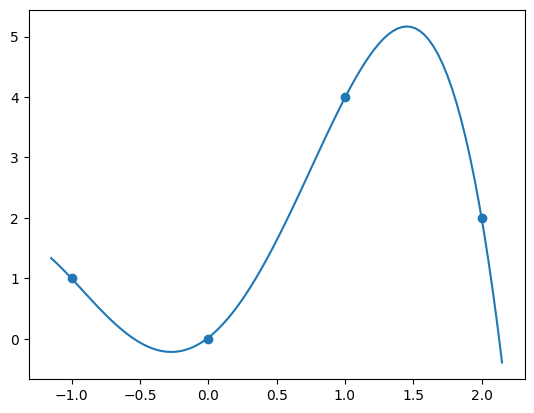

In [206]:
X = np.array([0, 2, -1, 1])
y = np.array([0, 2, 1, 4])
polyRegSolve(X, y, 4, 0.001)

### Toy example: fit to polynomial

In these examples, I provide a polynomial which I want my code to predict. I just compute the data by calling the polynomial on the x values specified and see what the model predicts on that data (hopefully giving the original polynomial)

In this first case, we have a 2nd degree polynomial on 3 points. It should exactly fit. In reality, it is not exact but is very close to pi on the first term, and since the other terms are correct it is pretty much spot on. no regularization needed.

3.1416x^2 + 4.0x^1 + 5.0
MSE: 3.365806528942984e-27


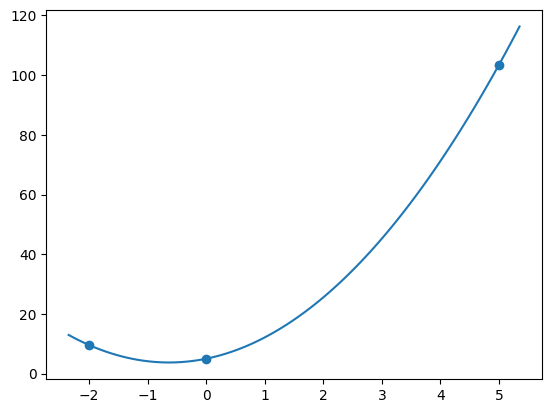

In [207]:
custompoly = lambda x: 3.141592653*x**2 + 4*x + 5
guessPolyTest(custompoly, 2, 0, xs=np.array([0, -2, 5]))

4th degree polynomial on 3 points, need some regularization for it to work

in this case, since i have 3 points only and they are close enough, the x^2 and x terms are not important when it comes to fitting

12.2776x^4 + 6.4809x^3 + -0.7165x^2 + 0.863x^1 + 4.999
MSE: 7.177168947513579e-07


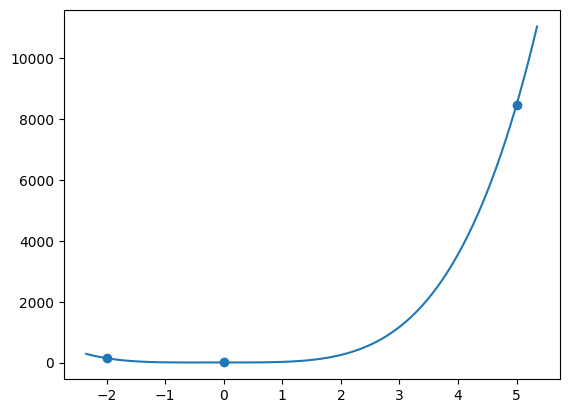

In [208]:
custompoly = lambda x: 12 * x**4 + 7*x**3 + 3*x**2 + 4*x + 5
guessPolyTest(custompoly, 4, 0.001, xs=np.array([0, -2, 5]))

## Example: estimate constant of gravity

As a first test of your polynomial regression class, see if you can fit a quadratic to this data coming from a falling ball. Physics predicts it should be
$$h(t) = h_0 + v_0 \cdot t - \frac{g}{2} \cdot t^2,$$

where $g$ (in units of $m/s^2$) is Earth's gravitational constant, giving the rate of downward acceleration. Find the best quadratic to fit this data to estimate $g$.

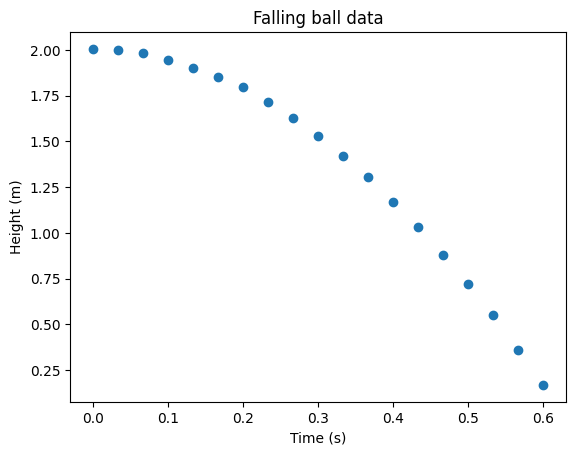

In [209]:
## data collected from https://www.youtube.com/watch?v=OEcyVzwciCs&ab_channel=ISLEPhysics

y = np.array([200.5, 200, 198, 194.5, 190.2, 185, 179.5, 171.5, 163, 153, 142.2, 130.3, 117, 103, 88, 72, 55, 36, 17]) / 100
X = np.linspace(0, 0.6, len(y))
plt.scatter(X, y)
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Falling ball data')
plt.show()

my code estimates 4.9185*2 = 9.837 which is pretty close

-4.9185x^2 + -0.1169x^1 + 2.0078
MSE: 8.28536331334138e-06


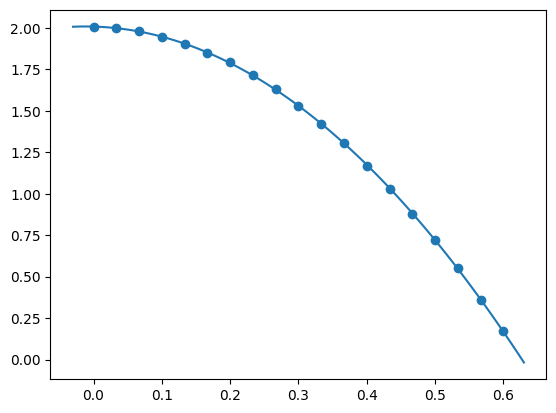

In [210]:
y = np.array([200.5, 200, 198, 194.5, 190.2, 185, 179.5, 171.5, 163, 153, 142.2, 130.3, 117, 103, 88, 72, 55, 36, 17]) / 100
X = np.linspace(0, 0.6, len(y))
polyRegSolve(X, y, 2, 0.0000001)

## Polynomial Fit Challenge

I generated some secret polynomials of unknown degree, and made some data coming from those polynomials plus noise. Try to see if you can choose the set of hyperparameters (find the degree, potentially also add some regularization) that you think fits this curve best. This should involve using a validation set, and because this dataset is pretty small, you should probably do k-fold cross validation.

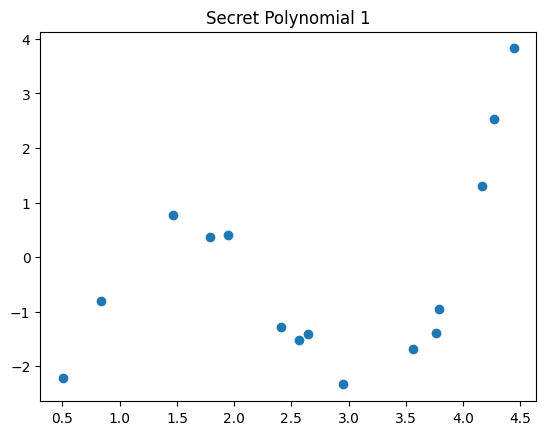

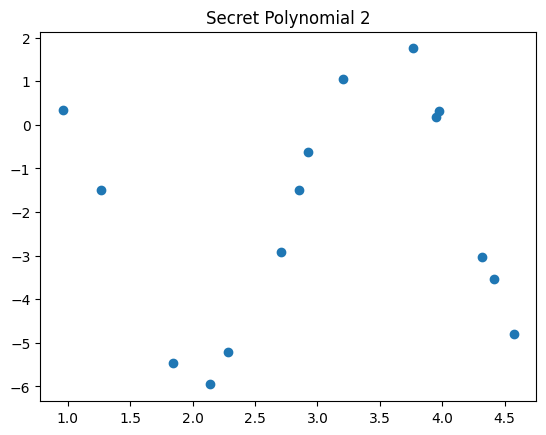

In [211]:
#@title Secret Polynomial Data
X1 = np.array([0.83970458, 2.40610534, 3.76390206, 1.94490536, 1.46855566,
        4.16853106, 3.5634144 , 3.79075211, 2.64154307, 0.50235891,
        4.27398109, 2.56718095, 1.78668299, 2.95250866, 4.44177834])
y1 = np.array([-0.7998434 , -1.27457238, -1.39327239,  0.40397065,  0.77856359,
         1.30030232, -1.69004943, -0.95285154, -1.40697462, -2.21800949,
         2.52442274, -1.52665889,  0.36616866, -2.33361331,  3.82489208])

X2 = np.array([1.26972919, 2.70559656, 3.95024355, 2.28282991, 1.84617602,
        4.32115347, 3.7664632 , 3.9748561 , 2.92141448, 0.96049567,
        4.417816  , 2.8532492 , 2.13779274, 3.20646627, 4.57163015])
y2 = np.array([-1.49414272, -2.90793443,  0.18976953, -5.20970387, -5.46367805,
        -3.03467102,  1.74949701,  0.31525131, -0.62679552,  0.34966043,
        -3.54403658, -1.4938531 , -5.95457108,  1.04509299, -4.79711428])

plt.scatter(X1, y1)
plt.title('Secret Polynomial 1')
plt.figure()
plt.title('Secret Polynomial 2')
plt.scatter(X2, y2)
plt.show()

In [212]:
def train_test_split(*arrays, rng_seed = 16, percent_train = 0.8):
    rng = np.random.default_rng(seed=rng_seed)
    l = rng.permutation(len(arrays[0]))
    return [(i[l[:int(percent_train*len(i))]], i[l[int(percent_train*len(i)):]]) for i in arrays]

In [213]:
def kFoldOptim(X, y, k, degs, regs, tts=0.2):
    '''returns best model'''
    (X_train, X_test), (y_train, y_test) = train_test_split(X, y, percent_train=1-tts)
    X_train_bits, X_val_bits, y_train_bits, y_val_bits = [], [], [], []
    dv = len(X)//k
    for _ in range(k):
        X_train_bits.append(X_train[dv:])
        X_val_bits.append(X_train[:dv])
        y_train_bits.append(y_train[dv:])
        y_val_bits.append(y_train[:dv])
        np.roll(X_train, dv, 0)
    
    best_model = None
    best_err = None
    for d in degs:
        for r in regs:
            cur_err = []
            for i in range(k):
                train_X, val_X, train_y, val_y = X_train_bits[i], X_val_bits[i], y_train_bits[i], y_val_bits[i]
                model = PolynomialRegression(d, r)
                model.fit(train_X, train_y)
                cur_err.append(np.mean((model.predict(val_X) - val_y)**2))
            err = np.mean(cur_err)
            if best_model is None or err < best_err:
                best_model = (d, r)
                best_err = err

    model = PolynomialRegression(*best_model)
    model.fit(X_train, y_train)
    model.plot(X, y)
    plt.scatter(X_train, y_train, c="green", label="train")
    plt.scatter(X_test, y_test, c="blue", label="test")
    plt.legend()
    print(best_model)
    print(model)
    print("Train loss", np.mean((model.predict(X_train) - y_train)**2))
    print("Test loss", np.mean((model.predict(X_test) - y_test)**2))

For my optimization, im using degrees from 1 to 9 and powers of 0.1 as my regularization (along with just 0 reg).

(7, 0.00010000000000000002)
0.0197x^7 + -0.2812x^6 + 1.4575x^5 + -2.8987x^4 + 0.4639x^3 + 2.8184x^2 + 2.1497x^1 + -3.9278
Train loss 0.013531421279859143
Test loss 0.24913701232908056


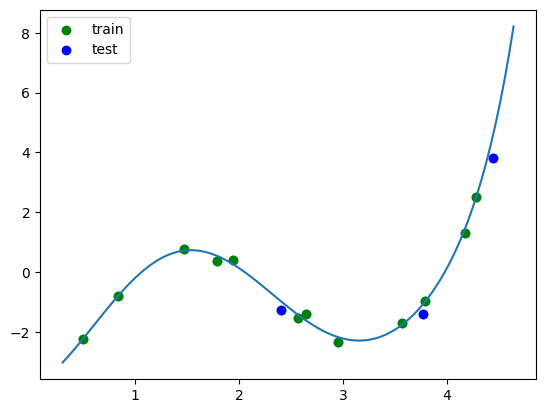

In [214]:
kFoldOptim(X1, y1, 4, np.arange(1, 10), [0] + list(0.1**np.arange(1, 5)))

visually, it looks like a 3rd degree polynomial, so just see what the best result for that is

1.0385x^3 + -7.1842x^2 + 14.086x^1 + -7.803
MSE: 0.04368872219141607


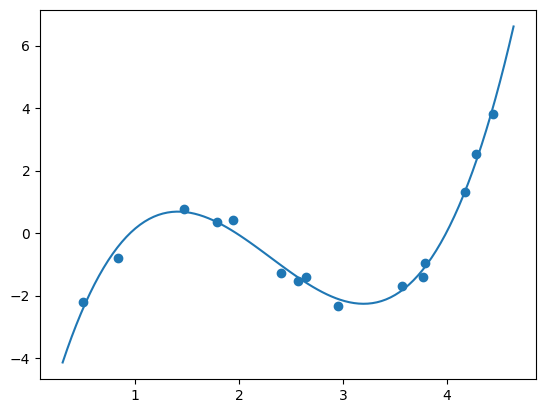

In [215]:
polyRegSolve(X1, y1, 3, 0)

(5, 0)
0.8258x^5 + -11.5544x^4 + 59.0057x^3 + -133.5981x^2 + 129.3539x^1 + -43.7868
Train loss 0.017377067764258524
Test loss 0.07712310386660813


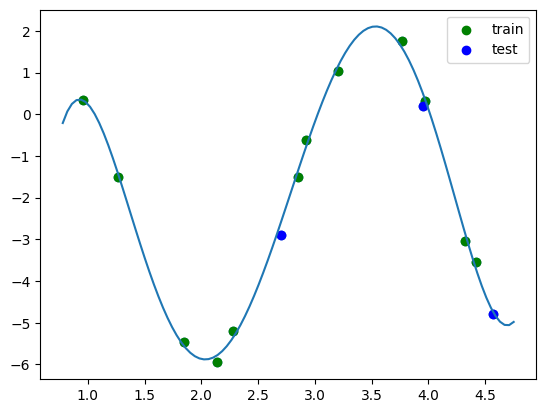

In [216]:
kFoldOptim(X2, y2, 4, np.arange(1, 10), [0] + list(0.1**np.arange(1, 5)))


This looks like a 3rd degree polynomial, so try that also (noticably worse loss)

-2.3061x^3 + 19.0878x^2 + -47.0233x^1 + 30.7219
MSE: 0.4934488504727565


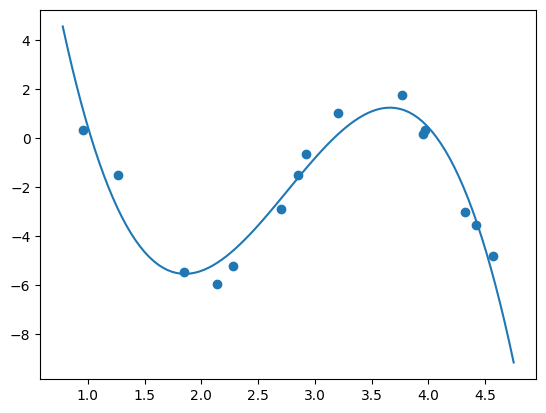

In [217]:
polyRegSolve(X2, y2, 3, 0.0000001)

# Sources and Reflection

documentation yay!

Credit to Jasper for helping me with solving the closed form for MultipleRegression (before we discussed it in class), and giving me his code for file reading (though I dumped most of it and replaced it with my own)


On a more technical note, I found that for PolynomialRegression generally 0.001 was a good regularization value (found it through kFoldOptim on powers of 0.1)

The assignment was pretty fun. I occasionally got a little lost in the math, but my classmates helped me understand it all. I was able to repay that by helping people (mostly just Thomas) with fixing some bits of their code (more so just identifying bugs that I had run into myself, and sharing how to fix them, rather than full-on debugging their code for them). I'm a little sad we won't get any more tiny data sets, but yay neural networks!